# Practical Statistics for Data Scientists (Python)
# Chapter 6. Statistical Machine Learning
> (c) 2019 Peter C. Bruce, Andrew Bruce, Peter Gedeck

Import required Python packages.

In [23]:
import math
import os
import random
from pathlib import Path
from collections import defaultdict
from itertools import product
import tqdm


import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

from dmba import plotDecisionTree, textDecisionTree

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

%matplotlib inline

In [2]:
try:
    import common
    DATA = common.dataDirectory()
except ImportError:
    DATA = Path().resolve() / 'data'

Define paths to data sets. If you don't keep your data in the same directory as the code, adapt the path names.

In [3]:
LOAN200_CSV = DATA / 'loan200.csv'
LOAN3000_CSV = DATA / 'loan3000.csv'
LOAN_DATA_CSV = DATA / 'loan_data.csv.gz'

Set this if the notebook crashes in the XGBoost part.

In [4]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

# K-Nearest Neighbors
## A Small Example: Predicting Loan Default

In [14]:
loan200 = pd.read_csv(LOAN200_CSV)
 
predictors = ['payment_inc_ratio', 'dti']
outcome = 'outcome'


newloan = loan200.loc[0:0, predictors]
X = loan200.loc[1:, predictors]
y = loan200.loc[1:, outcome]

knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X, y)
knn.predict(newloan)
print(knn.predict_proba(newloan))

[[0.75 0.25]]


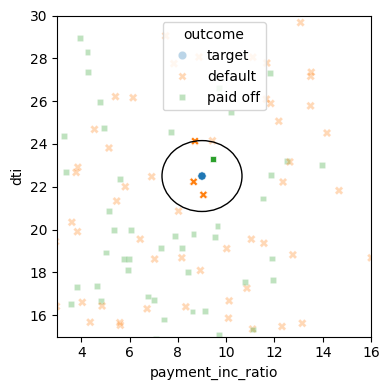

In [15]:
nbrs = knn.kneighbors(newloan)
maxDistance = np.max(nbrs[0][0])

fig, ax = plt.subplots(figsize=(4, 4))
sns.scatterplot(x='payment_inc_ratio', y='dti', style='outcome', 
                hue='outcome', data=loan200, alpha=0.3, ax=ax)
sns.scatterplot(x='payment_inc_ratio', y='dti', style='outcome', 
                hue='outcome', 
                data=pd.concat([loan200.loc[0:0, :], loan200.loc[nbrs[1][0] + 1,:]]), 
                ax=ax, legend=False)
ellipse = Ellipse(xy=newloan.values[0], 
                  width=2 * maxDistance, height=2 * maxDistance,
                  edgecolor='black', fc='None', lw=1)
ax.add_patch(ellipse)
ax.set_xlim(3, 16)
ax.set_ylim(15, 30)

plt.tight_layout()
plt.show()

## Standardization (Normalization, Z-Scores)

In [16]:
loan_data = pd.read_csv(LOAN_DATA_CSV)
loan_data = loan_data.drop(columns=['Unnamed: 0', 'status'])
loan_data['outcome'] = pd.Categorical(loan_data['outcome'], 
                                      categories=['paid off', 'default'], 
                                      ordered=True)


predictors = ['payment_inc_ratio', 'dti', 'revol_bal', 'revol_util']
outcome = 'outcome'

newloan = loan_data.loc[0:0, predictors]
print(newloan)
X = loan_data.loc[1:, predictors]
y = loan_data.loc[1:, outcome]

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X, y)

nbrs = knn.kneighbors(newloan)
print(X.iloc[nbrs[1][0], :])

   payment_inc_ratio  dti  revol_bal  revol_util
0             2.3932  1.0       1687         9.4
       payment_inc_ratio   dti  revol_bal  revol_util
35536            1.47212  1.46       1686        10.0
33651            3.38178  6.37       1688         8.4
25863            2.36303  1.39       1691         3.5
42953            1.28160  7.14       1684         3.9
43599            4.12244  8.98       1684         7.2


In [18]:
newloan = loan_data.loc[0:0, predictors]
X = loan_data.loc[1:, predictors]
y = loan_data.loc[1:, outcome]

scaler = preprocessing.StandardScaler()
scaler.fit(X * 1.0)

X_std = scaler.transform(X * 1.0)
newloan_std = scaler.transform(newloan * 1.0)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_std, y)

nbrs = knn.kneighbors(newloan_std)
print(X.iloc[nbrs[1][0], :])

       payment_inc_ratio   dti  revol_bal  revol_util
2080             2.61091  1.03       1218         9.7
1438             2.34343  0.51        278         9.9
30215            2.71200  1.34       1075         8.5
28542            2.39760  0.74       2917         7.4
44737            2.34309  1.37        488         7.2


## KNN as a Feature Engine

count    45342.000000
mean         0.501099
std          0.128735
min          0.000000
25%          0.400000
50%          0.500000
75%          0.600000
max          0.950000
Name: borrower_score, dtype: float64


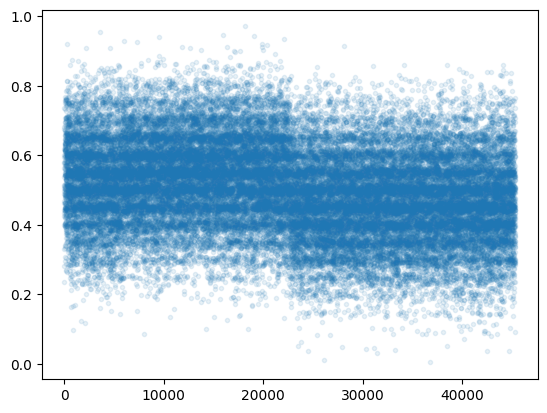

In [21]:
loan_data = pd.read_csv(LOAN_DATA_CSV)
loan_data = loan_data.drop(columns=['Unnamed: 0', 'status'])
loan_data['outcome'] = pd.Categorical(loan_data['outcome'], 
                                      categories=['paid off', 'default'], 
                                      ordered=True)

predictors = ['dti', 'revol_bal', 'revol_util', 'open_acc', 
              'delinq_2yrs_zero', 'pub_rec_zero']
outcome = 'outcome'

X = loan_data[predictors]
y = loan_data[outcome]

knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X, y)
plt.scatter(range(len(X)), [bs + random.gauss(0, 0.015) for bs in knn.predict_proba(X)[:,0]], 
            alpha=0.1, marker='.')
knn.predict_proba(X)[:, 0]

loan_data['borrower_score'] = knn.predict_proba(X)[:, 0]
print(loan_data['borrower_score'].describe())

# Tree Models
## A Simple Example
The package _scikit-learn_ has the class `DecisionTreeClassifier` to build a decision tree model. The function `plotDecisionTree` from the _dmba_ package can be used to visualize the tree. 

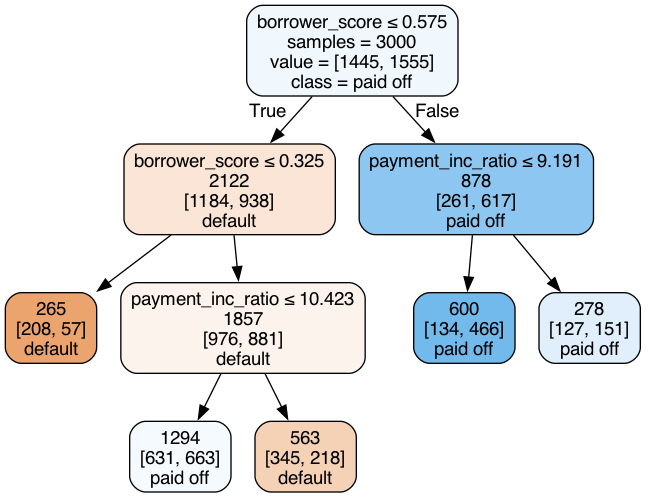

In [44]:
loan3000 = pd.read_csv(LOAN3000_CSV)

predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = loan3000[outcome]

loan_tree = DecisionTreeClassifier(random_state=1, criterion='entropy',
                                   min_impurity_decrease=0.005)
## by adjust the min_impurity_decrease, we can control the depth of the tree
loan_tree.fit(X, y)
plotDecisionTree(loan_tree, feature_names=predictors, class_names=loan_tree.classes_)

In [11]:
print(textDecisionTree(loan_tree))

node=0 test node: go to node 1 if 0 <= 0.5750000178813934 else to node 6
  node=1 test node: go to node 2 if 0 <= 0.32500000298023224 else to node 3
    node=2 leaf node: [[0.785, 0.215]]
    node=3 test node: go to node 4 if 1 <= 10.42264986038208 else to node 5
      node=4 leaf node: [[0.488, 0.512]]
      node=5 leaf node: [[0.613, 0.387]]
  node=6 test node: go to node 7 if 1 <= 9.19082498550415 else to node 10
    node=7 test node: go to node 8 if 0 <= 0.7249999940395355 else to node 9
      node=8 leaf node: [[0.247, 0.753]]
      node=9 leaf node: [[0.073, 0.927]]
    node=10 leaf node: [[0.457, 0.543]]


## The Recursive Partitioning Algorithm

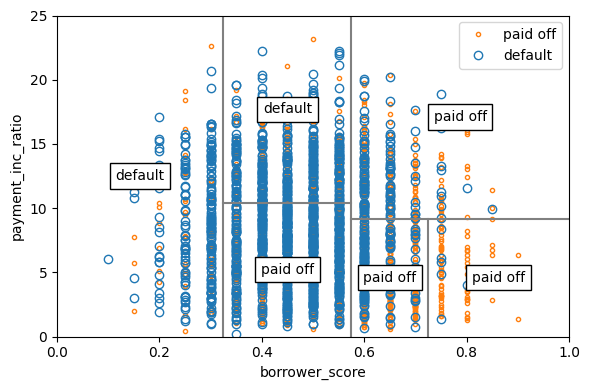

In [45]:
fig, ax = plt.subplots(figsize=(6, 4))

loan3000.loc[loan3000.outcome=='paid off'].plot(
    x='borrower_score', y='payment_inc_ratio', style='.', 
    markerfacecolor='none', markeredgecolor='C1', ax=ax)
loan3000.loc[loan3000.outcome=='default'].plot(
    x='borrower_score', y='payment_inc_ratio', style='o', 
    markerfacecolor='none', markeredgecolor='C0', ax=ax)
ax.legend(['paid off', 'default']);
ax.set_xlim(0, 1)
ax.set_ylim(0, 25)
ax.set_xlabel('borrower_score')
ax.set_ylabel('payment_inc_ratio')

x0 = 0.575
x1a = 0.325; y1b = 9.191
y2a = 10.423; x2b = 0.725
ax.plot((x0, x0), (0, 25), color='grey')
ax.plot((x1a, x1a), (0, 25), color='grey')
ax.plot((x0, 1), (y1b, y1b), color='grey')
ax.plot((x1a, x0), (y2a, y2a), color='grey')
ax.plot((x2b, x2b), (0, y1b), color='grey')

labels = [('default', (x1a / 2, 25 / 2)),
          ('default', ((x0 + x1a) / 2, (25 + y2a) / 2)),
          ('paid off', ((x0 + x1a) / 2, y2a / 2)),
          ('paid off', ((1 + x0) / 2, (y1b + 25) / 2)),
          ('paid off', ((1 + x2b) / 2, (y1b + 0) / 2)),
          ('paid off', ((x0 + x2b) / 2, (y1b + 0) / 2)),
         ]
for label, (x, y) in labels:
    ax.text(x, y, label, bbox={'facecolor':'white'},
            verticalalignment='center', horizontalalignment='center')

plt.tight_layout()
plt.show()

## Measuring Homogeneity or Impurity

In [46]:
def entropyFunction(x):
    if x == 0: return 0
    return -x * math.log(x, 2) - (1 - x) * math.log(1 - x, 2)

def giniFunction(x):
    return x * (1 - x)

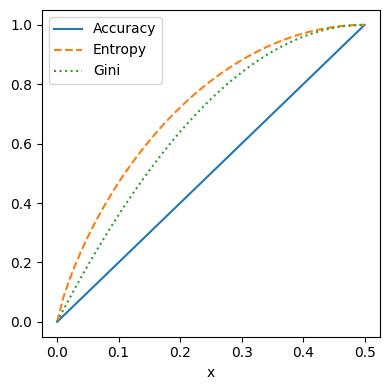

In [47]:
x = np.linspace(0, 0.5, 50)
impure = pd.DataFrame({
    'x': x,
    'Accuracy': 2 * x,
    'Gini': [giniFunction(xi) / giniFunction(.5) for xi in x],
    'Entropy': [entropyFunction(xi) for xi in x],
})

fig, ax = plt.subplots(figsize=(4, 4))

impure.plot(x='x', y='Accuracy', ax=ax, linestyle='solid')
impure.plot(x='x', y='Entropy', ax=ax, linestyle='--')
impure.plot(x='x', y='Gini', ax=ax, linestyle=':')

plt.tight_layout()
plt.show()

# Bagging and the Random Forest
## Random Forest

In [69]:
predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = loan3000[outcome]

rf = RandomForestClassifier(n_estimators=500, random_state=1, 
                            oob_score=True)
## n_estimators is the number of trees in the forest， oob_score is the out-of-bag score， random_state is the seed
rf.fit(X, y)
print(rf.oob_decision_function_)

[[0.18131868 0.81868132]
 [0.26704545 0.73295455]
 [0.93333333 0.06666667]
 ...
 [1.         0.        ]
 [0.73157895 0.26842105]
 [0.68085106 0.31914894]]


In [70]:
n_estimator = list(range(20, 510, 5))
oobScores = []
for n in n_estimator:
    rf = RandomForestClassifier(n_estimators=n, 
                                criterion='entropy', max_depth=5,
                                random_state=1, oob_score=True)
    rf.fit(X, y)
    oobScores.append(rf.oob_score_)

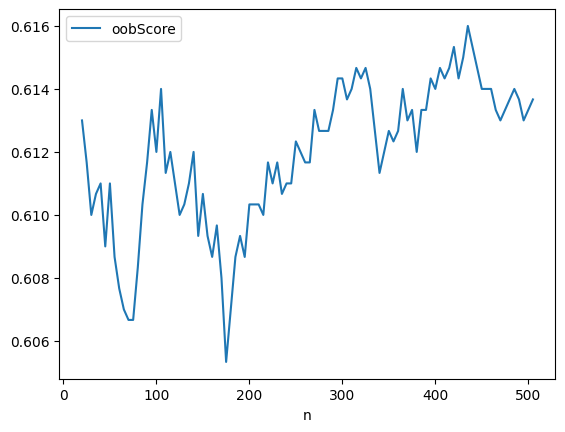

In [71]:
pd.DataFrame({
    'n': n_estimator, 
    'oobScore': oobScores
}).plot(x='n', y='oobScore')
plt.show()

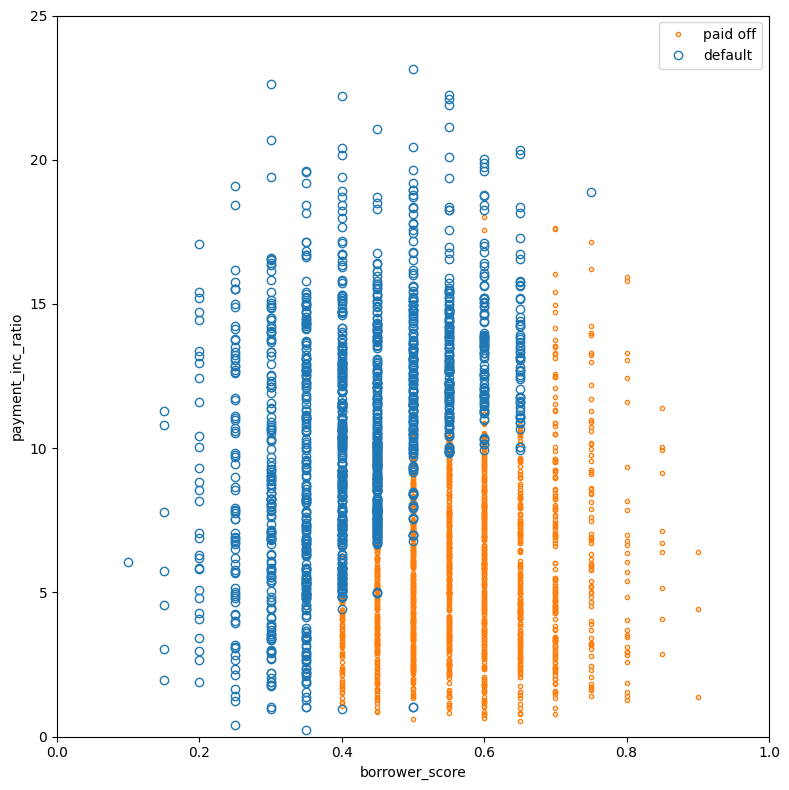

In [72]:
predictions = X.copy()
predictions['prediction'] = rf.predict(X)
predictions.head()

fig, ax = plt.subplots(figsize=(8, 8))

predictions.loc[predictions.prediction=='paid off'].plot(
    x='borrower_score', y='payment_inc_ratio', style='.',
    markerfacecolor='none', markeredgecolor='C1', ax=ax)
predictions.loc[predictions.prediction=='default'].plot(
    x='borrower_score', y='payment_inc_ratio', style='o',
    markerfacecolor='none', markeredgecolor='C0', ax=ax)
ax.legend(['paid off', 'default'])
ax.set_xlim(0, 1)
ax.set_ylim(0, 25)
ax.set_xlabel('borrower_score')
ax.set_ylabel('payment_inc_ratio')

plt.tight_layout()
plt.show()

## Variable importance
This is different to R. The accuracy decrease is not available out of the box.

In [73]:
predictors = ['loan_amnt', 'term', 'annual_inc', 'dti', 
              'payment_inc_ratio', 'revol_bal', 'revol_util', 
              'purpose', 'delinq_2yrs_zero', 'pub_rec_zero', 
              'open_acc', 'grade', 'emp_length', 'purpose_', 
              'home_', 'emp_len_', 'borrower_score']
outcome = 'outcome'
#.get_dummies() is used to convert categorical variable into dummy/indicator variables
X = pd.get_dummies(loan_data[predictors], drop_first=True, dtype=int)
y = loan_data[outcome]

rf_all = RandomForestClassifier(n_estimators=500, random_state=1)
rf_all.fit(X, y)

rf_all_entropy = RandomForestClassifier(n_estimators=500, random_state=1,
                                        criterion='entropy')
print(rf_all_entropy.fit(X, y))

RandomForestClassifier(criterion='entropy', n_estimators=500, random_state=1)


In [76]:
from tqdm import tqdm
rf = RandomForestClassifier(n_estimators=500)
# create a dictionary to store the feature importances
scores = defaultdict(list)

# cross-validate the scores on a number of different random splits of the data
for _ in tqdm(range(3)):
    train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.3)
    rf.fit(train_X, train_y)
    acc = metrics.accuracy_score(valid_y, rf.predict(valid_X))
    for column in X.columns:
        X_t = valid_X.copy()
        X_t[column] = np.random.permutation(X_t[column].values)
        shuff_acc = metrics.accuracy_score(valid_y, rf.predict(X_t))
        scores[column].append((acc-shuff_acc)/acc)

print('Features sorted by their score:')
print(sorted([(round(np.mean(score), 4), feat) for feat, score in scores.items()], reverse=True))


100%|██████████| 3/3 [02:18<00:00, 46.21s/it]

Features sorted by their score:
[(0.0748, 'borrower_score'), (0.0323, 'grade'), (0.0299, 'term_60 months'), (0.0112, 'annual_inc'), (0.011, 'payment_inc_ratio'), (0.0039, 'dti'), (0.0033, 'revol_bal'), (0.0023, 'purpose_small_business'), (0.0016, 'purpose__small_business'), (0.0011, 'emp_length'), (0.0008, 'purpose_debt_consolidation'), (0.0008, 'open_acc'), (0.0006, 'purpose__major_purchase'), (0.0003, 'purpose_wedding'), (0.0003, 'purpose_moving'), (0.0003, 'emp_len__ > 1 Year'), (0.0003, 'delinq_2yrs_zero'), (0.0002, 'home__RENT'), (0.0001, 'purpose_vacation'), (0.0001, 'purpose_house'), (0.0001, 'loan_amnt'), (0.0, 'purpose_major_purchase'), (-0.0001, 'revol_util'), (-0.0001, 'purpose__debt_consolidation'), (-0.0003, 'purpose_medical'), (-0.0003, 'purpose_home_improvement'), (-0.0003, 'purpose_credit_card'), (-0.0003, 'purpose__medical'), (-0.0003, 'home__OWN'), (-0.0005, 'pub_rec_zero'), (-0.0006, 'purpose__other'), (-0.0006, 'purpose__home_improvement'), (-0.0008, 'purpose_other'

In [82]:
scores

defaultdict(list,
            {'loan_amnt': [-0.000221508472699213,
              -0.006505888951205821,
              0.00715307582260367],
             'annual_inc': [0.011518440580352219,
              0.004150308468872624,
              0.0180477605370309],
             'dti': [0.002215084726990792,
              0.003140773976444207,
              0.006492791900517111],
             'payment_inc_ratio': [0.013622771070993404,
              0.004038137969713836,
              0.015406624848684828],
             'revol_bal': [0.002325838963340231,
              0.0033651149747616145,
              0.004181798173214487],
             'revol_util': [-0.005869974526525632,
              0.0006730229949522212,
              0.004842082095300879],
             'delinq_2yrs_zero': [0.0017720677815925333,
              0.0,
              -0.0007703312424343743],
             'pub_rec_zero': [0.0,
              -0.0005608524957936024,
              -0.0008803785627820234],
             'ope

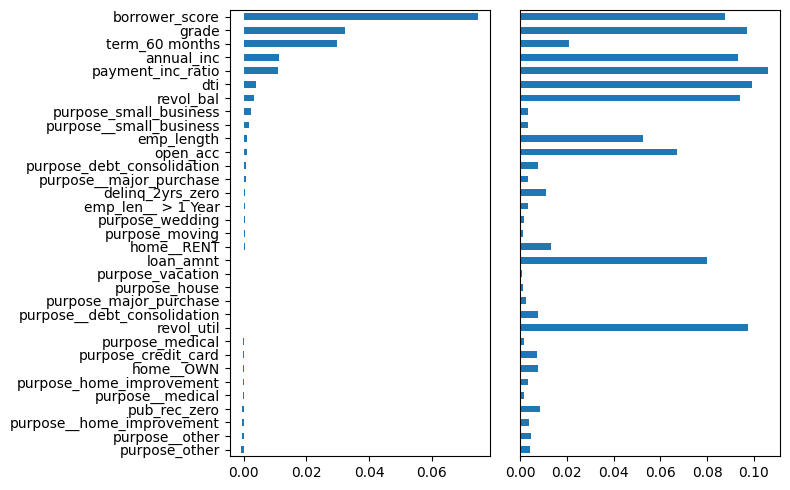

In [78]:
importances = rf_all.feature_importances_

#calculate the accuracy decrease for each feature
df = pd.DataFrame({
    'feature': X.columns, 
    'Accuracy decrease': [np.mean(scores[column]) for column in 
                         X.columns],
    'Gini decrease': rf_all.feature_importances_, 
    'Entropy decrease': rf_all_entropy.feature_importances_,
})
df = df.sort_values('Accuracy decrease')

fig, axes = plt.subplots(ncols=2, figsize=(8, 5))
ax = df.plot(kind='barh', x='feature', y='Accuracy decrease', 
             legend=False, ax=axes[0])
ax.set_ylabel('')

ax = df.plot(kind='barh', x='feature', y='Gini decrease', 
             legend=False, ax=axes[1])
ax.set_ylabel('')
ax.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()

# Boosting
## XGBoost

In [90]:
predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = pd.Series([1 if o == 'default' else 0 for o in loan3000[outcome]])
# use subsample makes boosting act like the random forest except the sampling is done without replacement.
# shrinkage parameter eta is used to prevent overfitting by reducing the weight of each tree's prediction..
xgb = XGBClassifier(objective='binary:logistic', subsample=.63, 
                    use_label_encoder=False, eval_metric='error')
print(xgb.fit(X, y))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)


In [91]:
xgb_df = X.copy()
xgb_df['prediction'] = ['default' if p == 1 else 'paid off' for p in xgb.predict(X)]
xgb_df['prob_default'] = xgb.predict_proba(X)[:, 0]
print(xgb_df.head())

   borrower_score  payment_inc_ratio prediction  prob_default
0            0.40            5.11135   paid off      0.586677
1            0.40            5.43165    default      0.307408
2            0.70            9.23003    default      0.337050
3            0.40            2.33482   paid off      0.861774
4            0.45           12.10320    default      0.056794


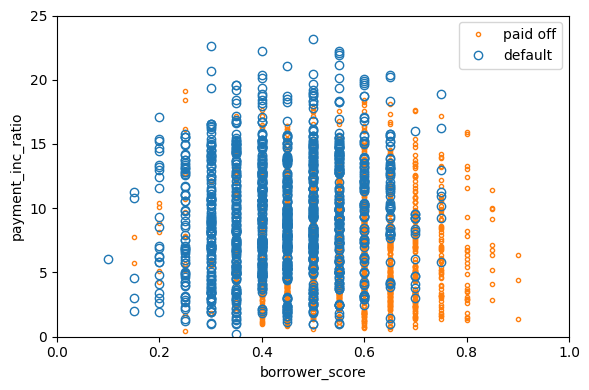

In [92]:
fig, ax = plt.subplots(figsize=(6, 4))

xgb_df.loc[xgb_df.prediction=='paid off'].plot(
    x='borrower_score', y='payment_inc_ratio', style='.', 
    markerfacecolor='none', markeredgecolor='C1', ax=ax)
xgb_df.loc[xgb_df.prediction=='default'].plot(
    x='borrower_score', y='payment_inc_ratio', style='o', 
    markerfacecolor='none', markeredgecolor='C0', ax=ax)
ax.legend(['paid off', 'default']);
ax.set_xlim(0, 1)
ax.set_ylim(0, 25)
ax.set_xlabel('borrower_score')
ax.set_ylabel('payment_inc_ratio')

plt.tight_layout()
plt.show()

## Regularization: Avoiding Overfitting

In [110]:
predictors = ['loan_amnt', 'term', 'annual_inc', 'dti', 
              'payment_inc_ratio', 'revol_bal', 'revol_util', 
              'purpose', 'delinq_2yrs_zero', 'pub_rec_zero', 
              'open_acc', 'grade', 'emp_length', 'purpose_', 
              'home_', 'emp_len_', 'borrower_score']
outcome = 'outcome'

X = pd.get_dummies(loan_data[predictors], drop_first=True, dtype=int)
y = pd.Series([1 if o == 'default' else 0 for o in loan_data[outcome]])

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=10000)

xgb_default = XGBClassifier(objective='binary:logistic', n_estimators=250, max_depth=6,
                            reg_lambda=0, learning_rate=0.5, subsample=1,
                            use_label_encoder=False, eval_metric='error')
xgb_default.fit(train_X, train_y)

xgb_penalty = XGBClassifier(objective='binary:logistic', n_estimators=250, max_depth=6,
                            reg_lambda=1000, learning_rate=0.1, subsample=0.63,
                            use_label_encoder=False, eval_metric='error')
print(xgb_penalty.fit(train_X, train_y))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)


In [112]:
pred_default = xgb_default.predict_proba(train_X)[:, 1]
error_default = abs(train_y - pred_default) > 0.5
print('default (train): ', np.mean(error_default))

pred_default = xgb_default.predict_proba(valid_X)[:, 1]
error_default = abs(valid_y - pred_default) > 0.5
print('default: ', np.mean(error_default))

pred_penalty = xgb_penalty.predict_proba(valid_X)[:, 1]
error_penalty = abs(valid_y - pred_penalty) > 0.5
print('penalty: ', np.mean(error_penalty))

default (train):  0.05704261218946296
default:  0.3797
penalty:  0.3293


In [1]:
results = []
for ntree_limit in tqdm(range(1, 250)):
    iteration_range = [1, ntree_limit + 1]
    train_default = xgb_default.predict_proba(train_X, iteration_range=iteration_range)[:, 1]
    train_penalty = xgb_penalty.predict_proba(train_X, iteration_range=iteration_range)[:, 1]
    pred_default = xgb_default.predict_proba(valid_X, iteration_range=iteration_range)[:, 1]
    pred_penalty = xgb_penalty.predict_proba(valid_X, iteration_range=iteration_range)[:, 1]
    results.append({
        'iterations': ntree_limit,
        'default train': np.mean(abs(train_y - train_default) > 0.5),
        'penalty train': np.mean(abs(train_y - train_penalty) > 0.5),
        'default test': np.mean(abs(valid_y - pred_default) > 0.5),
        'penalty test': np.mean(abs(valid_y - pred_penalty) > 0.5),
    })

results = pd.DataFrame(results)
print(results.head())

NameError: name 'tqdm' is not defined

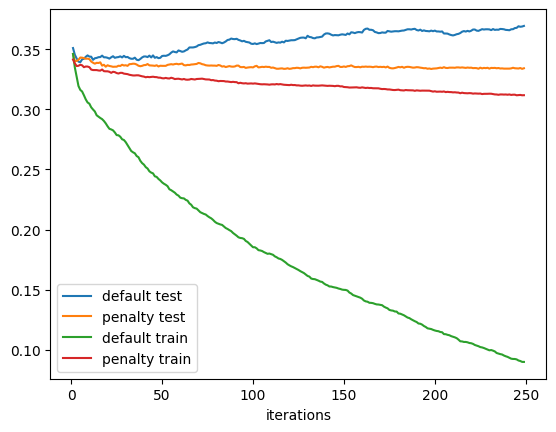

In [96]:
ax = results.plot(x='iterations', y='default test')
results.plot(x='iterations', y='penalty test', ax=ax)
results.plot(x='iterations', y='default train', ax=ax)
results.plot(x='iterations', y='penalty train', ax=ax)
plt.show()

## Hyperparameters and Cross-Validation

In [117]:
idx = np.random.choice(range(5), size=len(X), replace=True)
error = []
for eta, max_depth in product([0.1, 0.5, 0.9], [3, 6, 9]):
    xgb = XGBClassifier(objective='binary:logistic', n_estimators=250, 
                        max_depth=max_depth, learning_rate=eta,
                        eval_metric='error')
    cv_error = []
    for k in range(5):
        fold_idx = idx == k
        train_X = X.loc[~fold_idx]; train_y = y[~fold_idx]
        valid_X = X.loc[fold_idx]; valid_y = y[fold_idx]

        xgb.fit(train_X, train_y)
        pred = xgb.predict_proba(valid_X)[:, 1]
        cv_error.append(np.mean(abs(valid_y - pred) > 0.5))
    error.append({
        'eta': eta,
        'max_depth': max_depth,
        'avg_error': np.mean(cv_error)
    })
    print(error[-1])
errors = pd.DataFrame(error)
print(errors)

{'eta': 0.1, 'max_depth': 3, 'avg_error': 0.3285267878470843}
{'eta': 0.1, 'max_depth': 6, 'avg_error': 0.33672898477262697}
{'eta': 0.1, 'max_depth': 9, 'avg_error': 0.3475109024585764}
{'eta': 0.5, 'max_depth': 3, 'avg_error': 0.3393081344348275}
{'eta': 0.5, 'max_depth': 6, 'avg_error': 0.37067046517566316}
{'eta': 0.5, 'max_depth': 9, 'avg_error': 0.36950806993399615}
{'eta': 0.9, 'max_depth': 3, 'avg_error': 0.3541974836871339}
{'eta': 0.9, 'max_depth': 6, 'avg_error': 0.38893882087527326}
{'eta': 0.9, 'max_depth': 9, 'avg_error': 0.3817462356002767}
   eta  max_depth  avg_error
0  0.1          3   0.328527
1  0.1          6   0.336729
2  0.1          9   0.347511
3  0.5          3   0.339308
4  0.5          6   0.370670
5  0.5          9   0.369508
6  0.9          3   0.354197
7  0.9          6   0.388939
8  0.9          9   0.381746


In [121]:
print(errors.pivot_table(index='eta', columns='max_depth', values='avg_error') * 100)

max_depth          3          6          9
eta                                       
0.1        32.852679  33.672898  34.751090
0.5        33.930813  37.067047  36.950807
0.9        35.419748  38.893882  38.174624


In [122]:
errors

,eta,max_depth,avg_error
0,0.1,3,0.328527
1,0.1,6,0.336729
2,0.1,9,0.347511
3,0.5,3,0.339308
4,0.5,6,0.370670
5,0.5,9,0.369508
6,0.9,3,0.354197
7,0.9,6,0.388939
8,0.9,9,0.381746
